# Task2 

In [1]:
from typing import List

Ukkonen w rozszerzonej wersji

In [2]:
class Node:
    def __init__(self):
        self.children = {}
        self.suffix_link = None
        self.start = -1
        self.end = -1
        self.id = -1
        self.suffix_start = -1

class SuffixTree:
    def __init__(self, text: str):
        self.text = text + "$"
        self.n = len(self.text)
        self.root = Node()
        self.root.suffix_link = self.root
        self.active_node = self.root
        self.active_edge = 0
        self.active_length = 0
        self.remainder = 0
        self.global_end = -1
        self.node_count = 0
        self.build_tree()

    def get_edge_length(self, node):
        if node.end == -1:
            return self.global_end - node.start + 1
        else:
            return node.end - node.start + 1

    def walk_down(self, node):
        edge_length = self.get_edge_length(node)
        if self.active_length >= edge_length:
            self.active_edge += edge_length
            self.active_length -= edge_length
            self.active_node = node
            return True
        return False

    def new_node(self, start, end=None):
        node = Node()
        node.start = start
        if end is None:
            node.end = -1
        else:
            node.end = end
        node.id = self.node_count
        self.node_count += 1
        return node

    def build_tree(self):
        for i in range(self.n):
            self.global_end = i
            self.remainder += 1
            last_new_node = None
            
            while self.remainder > 0:
                if self.active_length == 0:
                    self.active_edge = i
                
                # Poprawka: sprawdzenie czy active_edge nie wykracza poza zakres
                if self.active_edge >= self.n:
                    break
                    
                current_char_for_edge = self.text[self.active_edge]

                if current_char_for_edge not in self.active_node.children:
                    # Tworzenie nowego liścia
                    leaf = self.new_node(i)
                    leaf.suffix_start = i - self.remainder + 1
                    self.active_node.children[current_char_for_edge] = leaf
                    
                    if last_new_node is not None:
                        last_new_node.suffix_link = self.active_node
                        last_new_node = None
                else:
                    next_node = self.active_node.children[current_char_for_edge]
                    
                    # Walk down jeśli to konieczne
                    if self.walk_down(next_node):
                        continue

                    # Sprawdzenie czy znak pasuje
                    next_char_pos = next_node.start + self.active_length
                    if next_char_pos < self.n and self.text[next_char_pos] == self.text[i]:
                        # Znak pasuje - kontynuujemy po krawędzi
                        if last_new_node is not None and self.active_node != self.root:
                            last_new_node.suffix_link = self.active_node
                            last_new_node = None
                        
                        self.active_length += 1
                        break
                    
                    # Znak nie pasuje - trzeba podzielić krawędź
                    split_end = next_node.start + self.active_length - 1
                    split_node = self.new_node(next_node.start, split_end)
                    
                    # Aktualizacja połączeń
                    self.active_node.children[current_char_for_edge] = split_node
                    
                    # Nowy liść z aktualnym znakiem
                    leaf = self.new_node(i)
                    leaf.suffix_start = i - self.remainder + 1
                    split_node.children[self.text[i]] = leaf
                    
                    # Aktualizacja istniejącego węzła
                    next_node.start += self.active_length
                    if next_node.start < self.n:
                        split_node.children[self.text[next_node.start]] = next_node
                    
                    # Suffix links
                    if last_new_node is not None:
                        last_new_node.suffix_link = split_node
                    
                    last_new_node = split_node
                
                self.remainder -= 1
                
                # Przejście do następnego sufiksu
                if self.active_node == self.root and self.active_length > 0:
                    self.active_length -= 1
                    self.active_edge = i - self.remainder + 1
                elif self.active_node != self.root:
                    if self.active_node.suffix_link is not None:
                        self.active_node = self.active_node.suffix_link
                    else:
                        self.active_node = self.root

    def find_pattern(self, pattern: str) -> list[int]:
        """Znajdź wszystkie wystąpienia wzorca w tekście"""
        if not pattern:
            return []
        
        current_node = self.root
        pattern_pos = 0
        pattern_len = len(pattern)
        
        while pattern_pos < pattern_len:
            char_to_match = pattern[pattern_pos]
            
            if char_to_match not in current_node.children:
                return []
            
            next_node = current_node.children[char_to_match]
            edge_len = self.get_edge_length(next_node)
            
            # Porównaj znaki na krawędzi z wzorcem
            chars_to_compare = min(edge_len, pattern_len - pattern_pos)
            
            for j in range(chars_to_compare):
                if (next_node.start + j < self.n and 
                    pattern_pos + j < pattern_len and
                    self.text[next_node.start + j] != pattern[pattern_pos + j]):
                    return []
            
            pattern_pos += chars_to_compare
            current_node = next_node
            
            # Jeśli dopasowaliśmy cały wzorzec ale nie cała krawędź
            if pattern_pos == pattern_len and chars_to_compare < edge_len:
                break
        
        # Zbierz wszystkie pozycje wystąpień
        positions = []
        self._collect_leaf_positions(current_node, positions)
        return sorted(list(set(positions)))

    def _collect_leaf_positions(self, node, positions):
        """Zbierz pozycje wszystkich liści w poddrzewie"""
        if not node.children:  # Liść
            if node.suffix_start != -1:
                positions.append(node.suffix_start)
        else:
            for child in node.children.values():
                self._collect_leaf_positions(child, positions)

    def get_all_substrings_with_positions(self):
        """Zwróć wszystkie podciągi z ich pozycjami"""
        substrings = {}
        self._dfs_substrings(self.root, "", substrings, 0)
        # Usuń sufiks zawierający $
        filtered = {k: v for k, v in substrings.items() if '$' not in k and k}
        return filtered
    
    def _dfs_substrings(self, node, current_string, substrings, depth):
        """DFS do zbierania wszystkich podciągów"""
        # Jeśli to liść, dodaj wszystkie prefiksy aktualnego ciągu
        if not node.children:
            if node.suffix_start != -1:
                # Dodaj wszystkie prefiksy (podciągi) aktualnego ciągu
                for i in range(1, len(current_string) + 1):
                    if current_string[i-1] == '$':  # Przerwij przed $
                        break
                    substr = current_string[:i]
                    if substr not in substrings:
                        substrings[substr] = []
                    substrings[substr].append(node.suffix_start)
        else:
            # Kontynuuj DFS dla dzieci
            for char, child in node.children.items():
                if child.start != -1 and child.start < self.n:
                    edge_text = self.text[child.start:child.start + self.get_edge_length(child)]
                    self._dfs_substrings(child, current_string + edge_text, substrings, depth + 1)


In [3]:
def build_suffix_array(s: str) -> List[int]:
    suffixes = [(s[i:], i) for i in range(len(s))]
    suffixes.sort()  # sortowanie 
    return [pos for _, pos in suffixes] # bruteforce n^2logn z wykladu

In [4]:
def longest_common_substring(str1: str, str2: str) -> str:
    if not str1 or not str2:  return ""
    
    combined = str1 + "#" + str2 # separator
    tree = SuffixTree(combined)
    
    str1_len = len(str1)
    longest = ""
    
    substrings = tree.get_all_substrings_with_positions() # wszystkie podciagi z pozycjami
    
    for substring, positions in substrings.items():
        if "#" in substring: continue # pomijamy te z separatorem
        
        if any(pos < str1_len for pos in positions) and any(pos > str1_len for pos in positions) and len(substring) > len(longest): # czy jest w obu
            longest = substring
    
    return longest

In [5]:
def longest_common_substring_multiple(strings: list[str]) -> str:
    if not strings: return ""
    
    if len(strings) == 1: return strings[0]
    separators = [chr(ord('!') + i) for i in range(len(strings))] # separatory
    
    combined = ""
    string_boundaries = [0]  # Pozycje poczatkow z combined
    
    for i, s in enumerate(strings):
        combined += s
        if i < len(strings) - 1: combined += separators[i]
        string_boundaries.append(len(combined) + (0 if i == len(strings) - 1 else 1))
    
    tree = SuffixTree(combined)
    substrings = tree.get_all_substrings_with_positions()
    
    longest = ""
    
    for substring, positions in substrings.items():
        if any(sep in substring for sep in separators):  continue
            
        strings_present = set()
        
        for pos in positions:
            for i in range(len(strings)):
                if string_boundaries[i] <= pos < string_boundaries[i+1] - (1 if i < len(strings) - 1 else 0):
                    strings_present.add(i)
                    break
        
        if len(strings_present) == len(strings) and len(substring) > len(longest):  longest = substring
    
    return longest

In [6]:
def longest_palindromic_substring(text: str) -> str:

    if not text: return ""
    
    if len(text) == 1: return text
    
    reversed_text = text[::-1]
    combined = text + "#" + reversed_text
    
    tree = SuffixTree(combined)
    substrings = tree.get_all_substrings_with_positions()
    
    text_len = len(text)
    longest_palindrome = text[0]  # minimum jeden znak
    
    for substring, positions in substrings.items():
        if "#" in substring or len(substring) <= len(longest_palindrome): continue
        
        if any(pos < text_len for pos in positions) and any(pos > text_len for pos in positions):
            for pos in positions:
                if pos < text_len:
                    # czy mozemy rozszerzyc do palindromu
                    candidate = text[pos:pos + len(substring)]
                    
                    # czy  palindrom
                    if candidate == candidate[::-1] and len(candidate) > len(longest_palindrome): longest_palindrome = candidate
                    
                    # Próbujemy rozszerzyc w obie strony
                    left = pos - 1
                    right = pos + len(substring)
                    current_palindrome = candidate
                    
                    while (left >= 0 and right < text_len and 
                           text[left] == text[right]):
                        current_palindrome = text[left] + current_palindrome + text[right]
                        left -= 1
                        right += 1
                    
                    if len(current_palindrome) > len(longest_palindrome): longest_palindrome = current_palindrome
    
    return longest_palindrome

In [7]:
def lcs_dynamic_programming(str1: str, str2: str) -> str:
    if not str1 or not str2: return ""
    
    m, n = len(str1), len(str2)
    # dp[i][j] przechowuje dlugosc najdluzszego wsolnego podciagu
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    max_length = 0
    ending_pos = 0
    
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if str1[i-1] == str2[j-1]:
                dp[i][j] = dp[i-1][j-1] + 1
                if dp[i][j] > max_length:
                    max_length = dp[i][j]
                    ending_pos = i
            else:
                dp[i][j] = 0
    
    return str1[ending_pos - max_length:ending_pos]

In [8]:
def lcs_suffix_array(str1: str, str2: str) -> str:
    if not str1 or not str2: return ""
    
    combined = str1 + "#" + str2 + "$"
    suffix_array = build_suffix_array(combined)
    
    str1_len = len(str1)
    longest = ""
    
    for i in range(len(suffix_array) - 1):
        pos1, pos2 = suffix_array[i], suffix_array[i + 1]
        
        if pos1 < str1_len != pos2 < str1_len:  
            suffix1 = combined[pos1:]
            suffix2 = combined[pos2:]
            
            common_len = 0
            min_len = min(len(suffix1), len(suffix2))
            
            while (common_len < min_len and suffix1[common_len] == suffix2[common_len] and suffix1[common_len] not in "#$"): common_len += 1
            
            if common_len > len(longest): longest = combined[pos1:pos1 + common_len]
    
    return longest

Testy

In [9]:
import random
import string
import time
import matplotlib.pyplot as plt
import psutil
import os


def generate_test_strings(length: int, alphabet_size: int = 4) -> tuple[str, str]:
    alphabet = string.ascii_lowercase[:alphabet_size]
    str1 = ''.join(random.choice(alphabet) for _ in range(length))
    str2 = ''.join(random.choice(alphabet) for _ in range(length))
    return str1, str2

def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss  # in bytes

def benchmark_algorithms():
    lengths = [100,200, 300,500,700]
    times_suffix_tree = []
    times_suffix_array = []
    times_dp = []

    mem_suffix_tree = []
    mem_suffix_array = []
    mem_dp = []

    for length in lengths:
        print(f"Testing length: {length}")
        test_cases = [generate_test_strings(length) for _ in range(5)]
        
        # Suffix Tree
        total_time = 0
        total_mem = 0
        for str1, str2 in test_cases:
            mem_before = get_memory_usage()
            start_time = time.time()
            longest_common_substring(str1, str2)
            total_time += time.time() - start_time
            mem_after = get_memory_usage()
            total_mem += (mem_after - mem_before)
        times_suffix_tree.append(total_time / len(test_cases))
        mem_suffix_tree.append(total_mem / len(test_cases))

        # Suffix Array
        total_time = 0
        total_mem = 0
        for str1, str2 in test_cases:
            mem_before = get_memory_usage()
            start_time = time.time()
            lcs_suffix_array(str1, str2)
            total_time += time.time() - start_time
            mem_after = get_memory_usage()
            total_mem += (mem_after - mem_before)
        times_suffix_array.append(total_time / len(test_cases))
        mem_suffix_array.append(total_mem / len(test_cases))

        # Dynamic Programming
        total_time = 0
        total_mem = 0
        for str1, str2 in test_cases:
            mem_before = get_memory_usage()
            start_time = time.time()
            lcs_dynamic_programming(str1, str2)
            total_time += time.time() - start_time
            mem_after = get_memory_usage()
            total_mem += (mem_after - mem_before)
        times_dp.append(total_time / len(test_cases))
        mem_dp.append(total_mem / len(test_cases))

    mem_suffix_tree = [m / 1024 for m in mem_suffix_tree]
    mem_suffix_array = [m / 1024 for m in mem_suffix_array]
    mem_dp = [m / 1024 for m in mem_dp]

    plt.figure(figsize=(14, 6))

    # Wykres czasu wykonania
    plt.subplot(1, 2, 1)
    plt.plot(lengths, times_suffix_tree, 'o-', label='Suffix Tree', linewidth=2)
    plt.plot(lengths, times_suffix_array, 's-', label='Suffix Array', linewidth=2)
    plt.plot(lengths, times_dp, '^-', label='Dynamic Programming', linewidth=2)
    plt.xlabel('Długość napisów', fontsize=12)
    plt.ylabel('Średni czas wykonania [s]', fontsize=12)
    plt.title('Wydajność czasowa', fontsize=14)
    plt.yscale('log')  # Logarytmiczna skala Y
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(lengths, times_suffix_tree, 'o-', label='Suffix Tree', linewidth=2)
    plt.plot(lengths, times_suffix_array, 's-', label='Suffix Array', linewidth=2)
    plt.plot(lengths, times_dp, '^-', label='Dynamic Programming', linewidth=2)
    plt.xlabel('Długość napisów', fontsize=12)
    plt.ylabel('Średni czas wykonania [s]', fontsize=12)
    plt.title('Wydajność czasowa', fontsize=14)
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend()

    # Wykres zużycia pamięci -> nie dziala
    # plt.subplot(1, 2, 2)
    # plt.plot(lengths, mem_suffix_tree, 'o-', label='Suffix Tree', linewidth=2)
    # plt.plot(lengths, mem_suffix_array, 's-', label='Suffix Array', linewidth=2)
    # plt.plot(lengths, mem_dp, '^-', label='Dynamic Programming', linewidth=2)
    # plt.xlabel('Długość napisów', fontsize=12)
    # plt.ylabel('Średnie zużycie pamięci [KB]', fontsize=12)
    # plt.title('Zużycie pamięci RAM', fontsize=14)
    # plt.yscale('log')  # Logarytmiczna skala Y (bo różnice są małe)
    # plt.grid(True, which="both", linestyle="--", alpha=0.5)
    # plt.legend()

    # plt.tight_layout()
    # plt.show()


    return lengths, times_suffix_tree, times_suffix_array, times_dp, mem_suffix_tree, mem_suffix_array, mem_dp


In [10]:
def test_all_functions():
    """Testowanie wszystkich zaimplementowanych funkcji"""
    print("=== TESTY FUNKCJI ===\n")
    
    # Test 1: Longest Common Substring dla dwóch stringów
    print("Test 1: Longest Common Substring (dwa stringi)")
    test_cases = [
        ("abcdef", "xabcdy", "abcd"),
        ("ABABC", "BABCA", "BABC"),
        ("banana", "ananas", "anana"),
        ("", "test", ""),
        ("same", "same", "same"),
        ("abcd", "efgh", "")
    ]
    
    for str1, str2, expected in test_cases:
        result = longest_common_substring(str1, str2)
        status = "✓" if result == expected else "✗"
        print(f"{status} '{str1}' & '{str2}' -> '{result}' (oczekiwane: '{expected}')")
    
    print()
    
    # Test 2: Longest Common Substring dla wielu stringów
    print("Test 2: Longest Common Substring (wiele stringów)")
    multi_test_cases = [
        (["ABAB", "BABA", "ABBA"], "AB"),  
        (["abc", "def", "ghi"], ""),
        (["same"], "same"),
        ([], "")
    ]
    
    for strings, expected in multi_test_cases:
        result = longest_common_substring_multiple(strings)
        if expected == "AB":
            status = "✓" if result in ["AB", "BA"] else "✗"
        else:
            status = "✓" if result == expected else "✗"
        print(f"{status} {strings} -> '{result}' (oczekiwane: '{expected}')")
    
    print()
    
    # Test 3: Longest Palindromic Substring
    print("Test 3: Longest Palindromic Substring")
    palindrome_tests = [
        ("babad", "bab"), 
        ("cbbd", "bb"),
        ("racecar", "racecar"),
        ("abcdef", "a"),  
        ("aabbaa", "aabbaa"),
        ("", ""),
        ("a", "a")
    ]
    
    for text, expected in palindrome_tests:
        result = longest_palindromic_substring(text)
        if expected in ["bab", "aba"] and result in ["bab", "aba"]:
            status = "✓"
        elif len(result) == len(expected) and result == result[::-1]:
            status = "✓"
        elif result == expected:
            status = "✓"
        else:
            status = "✗"
        print(f"{status} '{text}' -> '{result}' (oczekiwane: '{expected}' lub palindrom długości {len(expected)})")
    
    print()

In [11]:

test_all_functions()

=== TESTY FUNKCJI ===

Test 1: Longest Common Substring (dwa stringi)
✓ 'abcdef' & 'xabcdy' -> 'abcd' (oczekiwane: 'abcd')
✓ 'ABABC' & 'BABCA' -> 'BABC' (oczekiwane: 'BABC')
✓ 'banana' & 'ananas' -> 'anana' (oczekiwane: 'anana')
✓ '' & 'test' -> '' (oczekiwane: '')
✓ 'same' & 'same' -> 'same' (oczekiwane: 'same')
✓ 'abcd' & 'efgh' -> '' (oczekiwane: '')

Test 2: Longest Common Substring (wiele stringów)
✓ ['ABAB', 'BABA', 'ABBA'] -> 'BA' (oczekiwane: 'AB')
✓ ['abc', 'def', 'ghi'] -> '' (oczekiwane: '')
✓ ['same'] -> 'same' (oczekiwane: 'same')
✓ [] -> '' (oczekiwane: '')

Test 3: Longest Palindromic Substring
✓ 'babad' -> 'bab' (oczekiwane: 'bab' lub palindrom długości 3)
✓ 'cbbd' -> 'bb' (oczekiwane: 'bb' lub palindrom długości 2)
✓ 'racecar' -> 'racecar' (oczekiwane: 'racecar' lub palindrom długości 7)
✓ 'abcdef' -> 'a' (oczekiwane: 'a' lub palindrom długości 1)
✓ 'aabbaa' -> 'aabbaa' (oczekiwane: 'aabbaa' lub palindrom długości 6)
✓ '' -> '' (oczekiwane: '' lub palindrom długości 0)

Testing length: 100
Testing length: 200
Testing length: 300
Testing length: 500
Testing length: 700


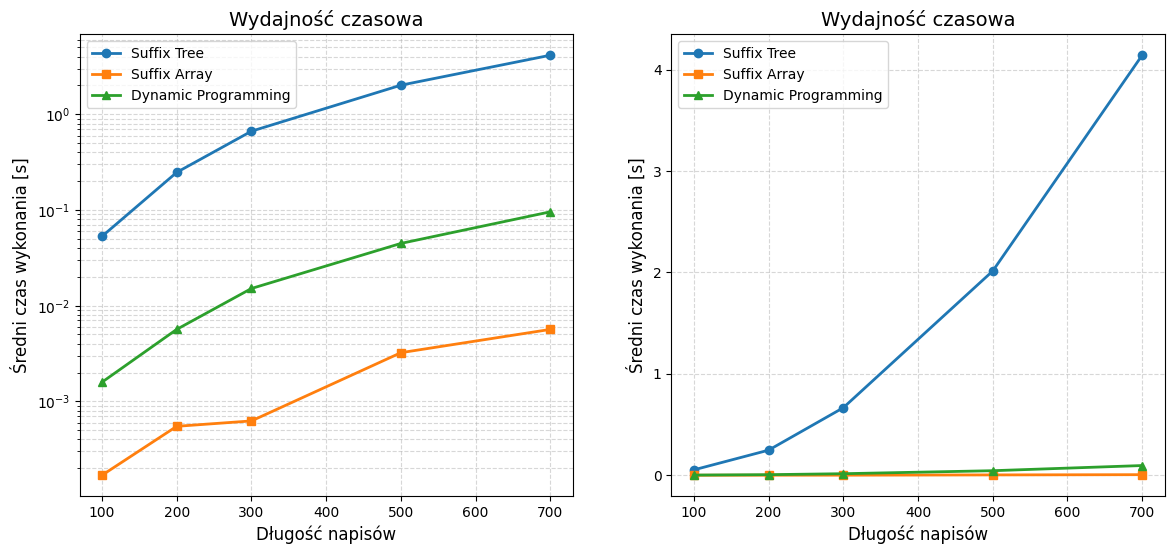

In [12]:

benchmark_results = benchmark_algorithms()